In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta

## Reflect Tables into SQLALchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
graph_data = calc_temps('2017-08-01', '2017-08-07')
graph_data

graph_df = pd.DataFrame(graph_data, columns=["TMIN", "TAVE", "TMAX"])

graph_df["EBAR"] = graph_df["TMAX"] - graph_df["TMIN"]
graph_df

,TMIN,TAVE,TMAX,EBAR
0,72.0,79.25,83.0,11.0


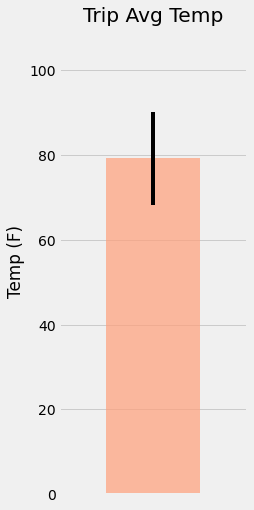

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ax = plt.axes()
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

temp_graph = graph_df.plot(kind = "bar", y="TAVE", yerr="EBAR", figsize=(3,8), facecolor="lightsalmon", alpha=0.7, ax=ax,
                          legend = False, title="Trip Avg Temp");
temp_graph.set_ylim(0,110);
temp_graph.grid(axis = 'x')
temp_graph.set_ylabel("Temp (F)");

### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.


sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation
      , func.sum(Measurement.prcp)]

rainfall = session.query(*sel).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())\
            .filter(Measurement.station == Station.station).filter(Measurement.date >= "2017-08-01")\
            .filter(Measurement.date <= "2017-08-07").all()

print(rainfall)

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_df = pd.DataFrame(rainfall, columns=["Station", "Name", "Lat", "Lng", "Elevation", "Precipitation"])
rainfall_df

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.22), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


,Station,Name,Lat,Lng,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


### Daily Temperature Normals

In [34]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017, 8, 1)
end_date = dt.date(2017, 8, 7)

# Use the start and end date to create a range of dates
num_days = end_date - start_date 

date_list = []

for day in range(num_days.days + 1):
    new_date = start_date + timedelta(days=day)
    date_list.append(new_date)
    
print(date_list)

# Strip off the year and save a list of strings in the format %m-%d
new_list = [dt.datetime.strftime(date, "%m-%d") for date in date_list]
new_list

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in new_list:
    result = daily_normals(date)
    normals.append(result)

normals

[datetime.date(2017, 8, 1), datetime.date(2017, 8, 2), datetime.date(2017, 8, 3), datetime.date(2017, 8, 4), datetime.date(2017, 8, 5), datetime.date(2017, 8, 6), datetime.date(2017, 8, 7)]


[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(columns =["tmin", "tavg", "tmax"])

for x in range(len(normals)):
    trip_df = trip_df.append(pd.DataFrame(normals[x],columns =["tmin", "tavg", "tmax"]))

trip_df["date"] = date_list
trip_df.set_index("date", inplace=True)

trip_df


C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_25968\1728887848.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trip_df = trip_df.append(pd.DataFrame(normals[x],columns =["tmin", "tavg", "tmax"]))
C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_25968\1728887848.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trip_df = trip_df.append(pd.DataFrame(normals[x],columns =["tmin", "tavg", "tmax"]))
C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_25968\1728887848.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trip_df = trip_df.append(pd.DataFrame(normals[x],columns =["tmin", "tavg", "tmax"]))
C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_25968\1728887848.py:5: FutureWarning: The frame.append method is deprecated and wil

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.54,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.25,83.0
2017-08-07,71.0,77.156863,83.0


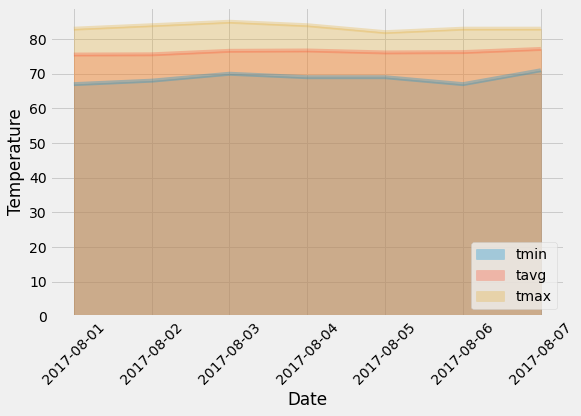

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.3, rot=45, figsize=(8,6))
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(loc="lower right");

## Close Session

In [40]:
session.close()